In [122]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score


# Загрузка данных

In [123]:
df = pd.read_csv('train_contest.csv', on_bad_lines='skip')
df.head()

,premium,name,department,has_test,response_letter_required,area,type,address,response_url,sort_point_distance,...,working_time_intervals,working_time_modes,accept_temporary,description,experience,key_skills,specializations,region,immediate_redirect_url,mean_salary
0,False,Агент по недвижимости,NaN,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Санкт-Петербург', 'street': 'Невский...",NaN,NaN,...,[],[],False,"<p>Мы ищем людей, которым не достаточно того, ...","{'id': 'noExperience', 'name': 'Нет опыта'}","[{'name': 'Жилая недвижимость'}, {'name': 'Акт...","[{'id': '20.20', 'name': 'Агент', 'profarea_id...",Санкт-Петербург,NaN,125000.0
1,False,IT-специалист/ техник,NaN,False,False,"{'id': '1130', 'name': 'Братск', 'url': 'https...","{'id': 'open', 'name': 'Открытая'}",NaN,NaN,NaN,...,[],[],False,<ul> </ul> <p><em><strong>Навыки</strong></em>...,"{'id': 'between1And3', 'name': 'От 1 года до 3...",[],"[{'id': '1.172', 'name': 'Начальный уровень, М...",Иркутская область,NaN,50000.0
2,False,Старший/ведущий инженер-программист,NaN,False,False,"{'id': '76', 'name': 'Ростов-на-Дону', 'url': ...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Ростов-на-Дону', 'street': '60К-9, 1...",NaN,NaN,...,[],[],False,<strong>Обязанности:</strong> <ul> <li>Разрабо...,"{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': 'Linux'}, {'name': 'Bash'}, {'name':...","[{'id': '1.221', 'name': 'Программирование, Ра...",Ростовская область,NaN,80000.0
3,False,Эксперт / методист приемной комиссии,NaN,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': '1-я Миусская ули...",NaN,NaN,...,[],[],False,<p>Департамент информационных технологий РХТУ ...,"{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': '1С программирование'}, {'name': 'Об...","[{'id': '3.150', 'name': 'Менеджмент продукта ...",Москва,NaN,120000.0
4,False,Табельщица/табельщик,NaN,False,False,"{'id': '1613', 'name': 'Энгельс', 'url': 'http...","{'id': 'open', 'name': 'Открытая'}","{'city': None, 'street': None, 'building': Non...",NaN,NaN,...,[],[],False,<p><strong>Обязанности:</strong></p> <ul> <li>...,"{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': 'Составление отчетности'}, {'name': ...","[{'id': '18.142', 'name': 'Машиностроение', 'p...",Саратовская область,NaN,15000.0


# Очистка и фиче-инженеринг

In [124]:
federal_districts = {
    "ЦФО": [
        "Москва", "Московская область", "Белгородская область", "Брянская область",
        "Владимирская область", "Воронежская область", "Ивановская область",
        "Калужская область", "Костромская область", "Курская область",
        "Липецкая область", "Орловская область", "Рязанская область",
        "Смоленская область", "Тамбовская область", "Тверская область",
        "Тульская область", "Ярославская область"
    ],
    "СЗФО": [
        "Санкт-Петербург", "Ленинградская область", "Архангельская область",
        "Вологодская область", "Калининградская область", "Мурманская область",
        "Новгородская область", "Псковская область", "Республика Карелия",
        "Республика Коми"
    ],
    "ЮФО": [
        "Краснодарский край", "Республика Адыгея", "Астраханская область",
        "Волгоградская область", "Ростовская область", "Республика Калмыкия",
        "Республика Крым"
    ],
    "СКФО": [
        "Ставропольский край", "Республика Дагестан", "Республика Ингушетия",
        "Кабардино-Балкарская республика", "Карачаево-Черкесская Республика",
        "Республика Северная Осетия-Алания", "Чеченская республика"
    ],
    "ПФО": [
        "Республика Татарстан", "Республика Башкортостан", "Кировская область",
        "Нижегородская область", "Оренбургская область", "Пензенская область",
        "Пермский край", "Самарская область", "Саратовская область",
        "Удмуртская Республика", "Ульяновская область", "Чувашская Республика",
        "Республика Марий Эл", "Республика Мордовия"
    ],
    "УФО": [
        "Свердловская область", "Челябинская область", "Тюменская область",
        "Ханты-Мансийский АО - Югра", "Ямало-Ненецкий АО", "Курганская область"
    ],
    "СФО": [
        "Красноярский край", "Республика Алтай", "Алтайский край",
        "Иркутская область", "Кемеровская область", "Новосибирская область",
        "Омская область", "Томская область", "Республика Тыва",
        "Республика Хакасия", "Забайкальский край"
    ],
    "ДФО": [
        "Приморский край", "Хабаровский край", "Амурская область",
        "Камчатский край", "Магаданская область", "Сахалинская область",
        "Республика Саха (Якутия)", "Республика Бурятия", "Еврейская АО"
    ]
}

region_to_district = {}
for district, regions in federal_districts.items():
    for region in regions:
        region_to_district[region] = district

df["federal_district"] = df["region"].map(region_to_district)


In [125]:
df['schedule'] = df['schedule'].str.replace(r".*'name':\s'(.*)'.*", r"\1", regex=True)
df['experience'] = df['experience'].str.replace(r".*'name':\s'(.*)'.*", r"\1", regex=True)

def extract_profarea_name_regex(text):
    match = re.search(r"'profarea_name'\s*:\s*'([^']+)'", text)
    if match:
        return match.group(1)
    return None

def extract_name_regex(text):
    match = re.search(r"'name'\s*:\s*'([^']+)'", text)
    if match:
        return match.group(1)
    return None

df['specialization_name'] = df['specializations'].apply(extract_name_regex)
df['prof_area_name'] = df['specializations'].apply(extract_profarea_name_regex)

In [126]:
df['experience'] = df['experience'].map({'Нет опыта':'0',
                                        'От 1 года до 3 лет':'1',
                                        'От 3 до 6 лет':'3',
                                        'Более 6 лет':'6'})

df['experience'] = df['experience'].astype('int64')

In [127]:
df = df[['name', 'prof_area_name', 'schedule', 'experience', 'region', 'federal_district', 'specialization_name', 'mean_salary']]
df = df.dropna()
df.head()

,name,prof_area_name,schedule,experience,region,federal_district,specialization_name,mean_salary
0,Агент по недвижимости,"Строительство, недвижимость",Гибкий график,0,Санкт-Петербург,СЗФО,Агент,125000.0
1,IT-специалист/ техник,"Информационные технологии, интернет, телеком",Вахтовый метод,1,Иркутская область,СФО,"Начальный уровень, Мало опыта",50000.0
2,Старший/ведущий инженер-программист,"Информационные технологии, интернет, телеком",Полный день,1,Ростовская область,ЮФО,"Программирование, Разработка",80000.0
3,Эксперт / методист приемной комиссии,"Маркетинг, реклама, PR",Полный день,1,Москва,ЦФО,Менеджмент продукта (Product manager),120000.0
4,Табельщица/табельщик,"Производство, сельское хозяйство",Полный день,1,Саратовская область,ПФО,Машиностроение,15000.0


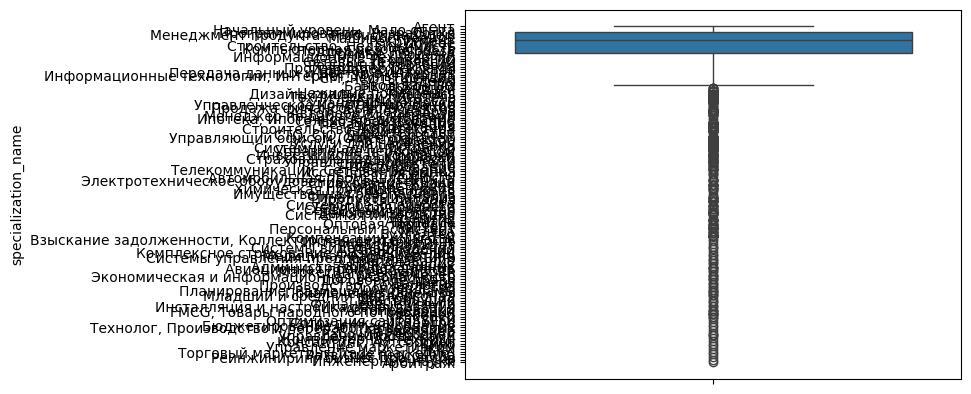

In [128]:
sns.boxplot(df['specialization_name'])
plt.show()

In [129]:
threshold = 50

category_counts = df['specialization_name'].value_counts()
df = df[df['specialization_name'].isin(category_counts.index[category_counts >= threshold])]

In [130]:
winsorized_values = winsorize(df['mean_salary'], limits=(0.05, 0.05))
df['mean_salary'] = winsorized_values

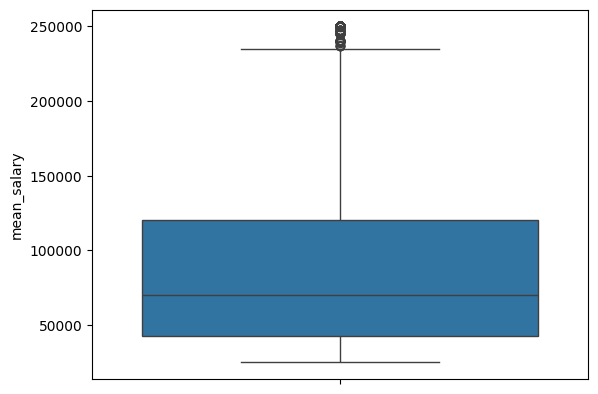

In [131]:
sns.boxplot(df['mean_salary'])
plt.show()

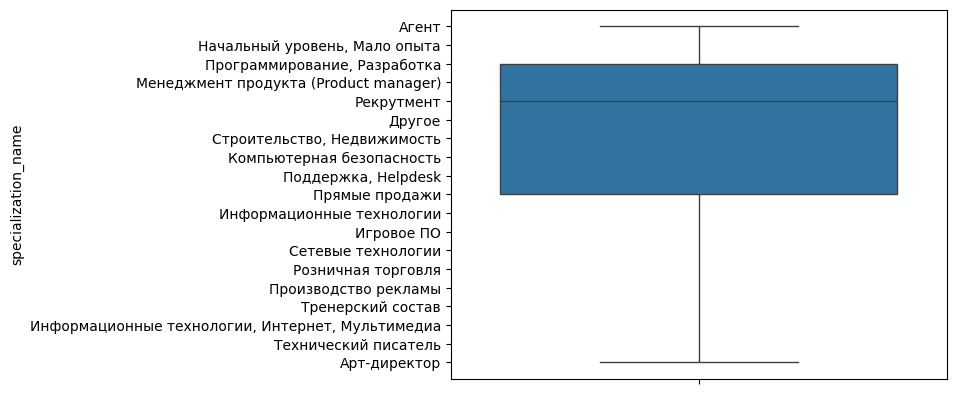

In [132]:
sns.boxplot(df['specialization_name'])
plt.show()

In [133]:
threshold = 10

category_counts = df['prof_area_name'].value_counts()
df = df[df['prof_area_name'].isin(category_counts.index[category_counts >= threshold])]

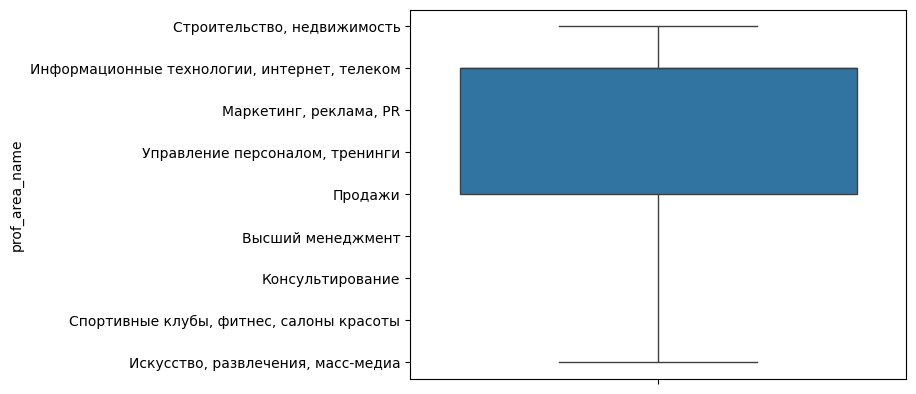

In [134]:
sns.boxplot(df['prof_area_name'])
plt.show()

# Кодирование признаков (сглаженный target encoding)

In [135]:
def mean_target_encode_smooth(df, cat_col, target_col, alpha=10):
    global_mean = df[target_col].mean()
    stats = df.groupby(cat_col)[target_col].agg(['mean', 'count'])
    smooth = (stats['count'] * stats['mean'] + alpha * global_mean) / (stats['count'] + alpha)
    return df[cat_col].map(smooth)


target_col = 'mean_salary'
cat_cols = df.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
    df[col + '_te'] = mean_target_encode_smooth(df, col, target_col, alpha=15)

df_encoded = df.drop(columns=cat_cols)
df_encoded.head()

,experience,mean_salary,name_te,prof_area_name_te,schedule_te,region_te,federal_district_te,specialization_name_te
0,0,125000.0,123891.197958,118145.377699,105917.764465,107139.020094,98567.935092,118145.377699
1,1,50000.0,87548.210438,91467.749720,99688.336731,68515.490136,76799.977351,44500.834456
2,1,80000.0,89423.210438,91467.749720,86311.866536,78295.603214,97314.907133,121437.363745
3,1,120000.0,91923.210438,73981.341188,86311.866536,123743.903875,103480.297576,119495.485703
5,3,100000.0,90673.210438,91467.749720,86311.866536,70584.464075,73195.822856,121437.363745


# Строим случайный лес

In [136]:
X = df_encoded.drop(columns=['mean_salary'])
y = df_encoded['mean_salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [137]:
model = RandomForestRegressor(n_estimators=100,
                              max_depth=9,
                              max_features=None, 
                              random_state=42,
                              bootstrap=True,
                              min_samples_split=5,
                              min_samples_leaf=5)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Оценка качества
rmse = root_mean_squared_error(y_train, y_pred_train)
print(f'RMSE train: {rmse:.2f}')
rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE test: {rmse:.2f}')
r2_score_train = r2_score(y_train, y_pred_train)
print(f'R2 train: {r2_score_train:.2f}')
r2_score_test = r2_score(y_test, y_pred)
print(f'R2 test: {r2_score_test:.2f}')


RMSE train: 25803.31
RMSE test: 27337.75
R2 train: 0.83
R2 test: 0.81
